# Trabajo Final Analisis Predictivo_Javier Gilabert Sabater

-----

# Theta, 4Theta y TBATS

## Analisis Serie Reservas

In [51]:
import warnings
warnings.filterwarnings('ignore')

In [52]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode

In [54]:
#Lectura
df_w_r = pd.read_csv('df_reservas.csv')
df_w_r['ArrivalDate'] = pd.to_datetime(df_w_r['ArrivalDate'])
df_w_r = df_w_r.set_index('ArrivalDate')
df_w_r.tail()

,IsCanceled
ArrivalDate,
2017-07-30,463
2017-08-06,452
2017-08-13,442
2017-08-20,465
2017-08-27,472


In [55]:
df_w_r_theta = df_w_r.copy()
df_w_r_theta.reset_index(level=0, inplace=True)

df_w_r_ts = TimeSeries.from_dataframe(df_w_r_theta,'ArrivalDate','IsCanceled')
train, test = df_w_r_ts.split_before(pd.Timestamp("20170806"))

In [56]:
test

<TimeSeries (DataArray) (ArrivalDate: 4, component: 1, sample: 1)>
array([[[452.]],

       [[442.]],

       [[465.]],

       [[472.]]])
Coordinates:
  * ArrivalDate  (ArrivalDate) datetime64[ns] 2017-08-06 ... 2017-08-27
  * component    (component) object 'IsCanceled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

-------

In [57]:

# %%
from darts.models import Theta, FourTheta
from darts.metrics import mape

model =Theta(seasonality_period=52) # Supone Theta 2
model.fit(train)
forecast = model.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(test, forecast)))




model Theta(seasonality_period=52) obtains MAPE: 17.76%


<Axes: xlabel='ArrivalDate'>

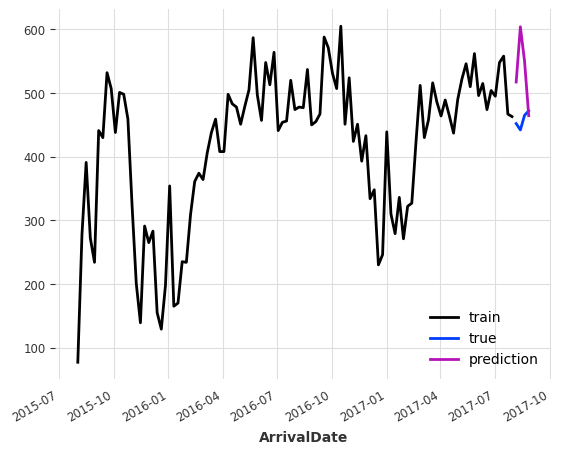

In [58]:
# %%
train.plot(label="train")
test.plot(label="true")
forecast.plot(label="prediction")

In [59]:

# %%
# Search for the best theta parameter, by trying 50 different values
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0




for theta in thetas:

    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mape(test, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta


In [60]:
best_theta

0.5714285714285712

In [61]:

# %%
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(test, pred_best_theta), best_theta
    )
)


The MAPE is: 2.89, with theta = 0.5714285714285712.


<Axes: xlabel='ArrivalDate'>

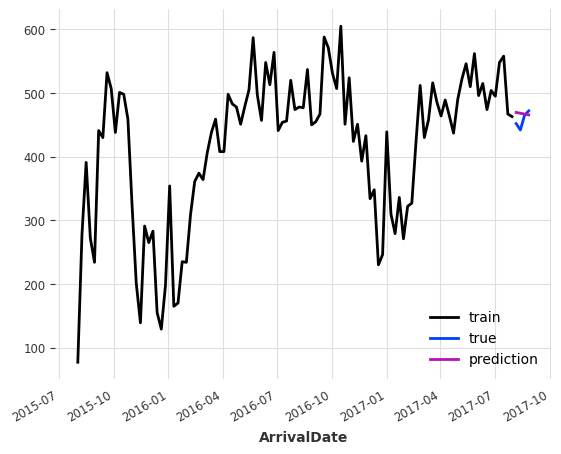

In [62]:
# %%
train.plot(label="train")
test.plot(label="true")
pred_best_theta.plot(label="prediction")

In [63]:
best_theta_mape_r = mape(test, pred_best_theta)
best_theta_mape_r

2.893985336864826

------

# 4Theta

In [64]:
model_4theta =FourTheta(seasonality_period=52)
model_4theta.fit(train)
matlab_4theta_pred = model_4theta.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model_4theta, mape(test, matlab_4theta_pred)))

model FourTheta(seasonality_period=52) obtains MAPE: 17.60%


Text(0.5, 1.0, 'model 4Theta')

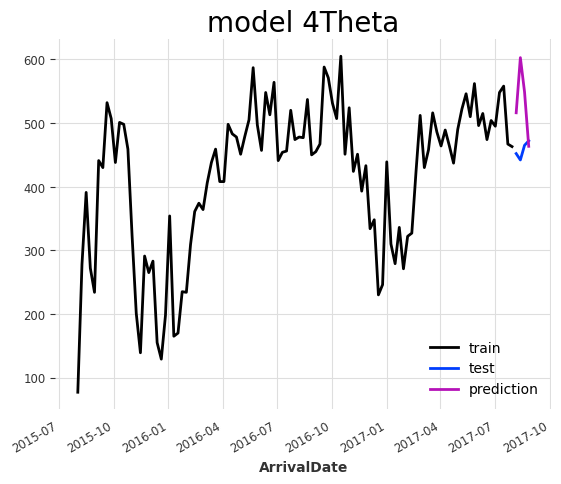

In [65]:
train.plot(label="train")
test.plot(label="test")
matlab_4theta_pred.plot(label="prediction")

plt.title(label="model 4Theta",
          fontsize=20,
          color="black")

In [66]:
fourtheta_grid = {
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=4, # 12
                                start=0.85,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

(FourTheta(theta=4, seasonality_period=None, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.LINEAR, normalization=True),
 {'theta': 4,
  'model_mode': <ModelMode.MULTIPLICATIVE: 'multiplicative'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.LINEAR: 'linear'>},
 8.71947850574284)

Text(0.5, 1.0, 'Best 4Theta model')

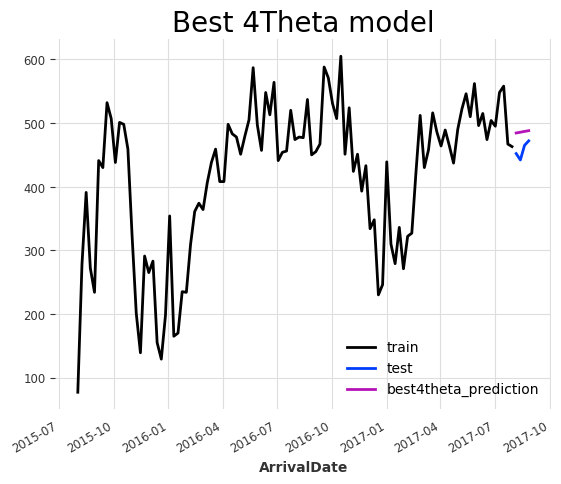

In [67]:
best4Theta_model=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.MULTIPLICATIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.LINEAR
                 )
best4Theta_model.fit(train)
best4Theta_model_prediction = best4Theta_model.predict(len(test))

train.plot(label="train")
test.plot(label="test")
best4Theta_model_prediction.plot(label="best4theta_prediction")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [68]:
best4theta_mape_r = mape(test, best4Theta_model_prediction)
best4theta_mape_r

6.277107991013731

-------

# TBATS

In [69]:
from darts.models import TBATS

In [70]:
model_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=100)
model_tbats.fit(train)
prediction_tbats = model_tbats.predict(len(test))

<Axes: xlabel='ArrivalDate'>

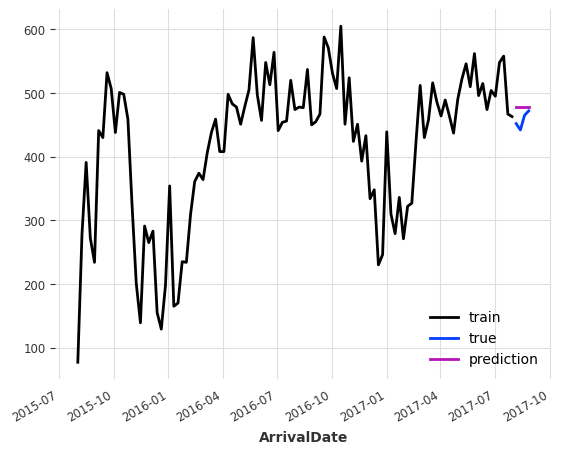

In [71]:
train.plot(label="train")
test.plot(label="true")
prediction_tbats.plot(label="prediction")

In [72]:
tbats_mape_r = mape(test, prediction_tbats)
tbats_mape_r

4.389299265803194

-----

# Analisis de Cancelaciones

In [73]:
#Lectura
df_w_c = pd.read_csv('df_cancelaciones.csv')
df_w_c['ArrivalDate'] = pd.to_datetime(df_w_c['ArrivalDate'])
df_w_c = df_w_c.set_index('ArrivalDate')
df_w_c.tail()

,IsCanceled
ArrivalDate,
2017-07-30,329
2017-08-06,251
2017-08-13,275
2017-08-20,332
2017-08-27,206


In [74]:
df_w_c_theta = df_w_c.copy()
df_w_c_theta.reset_index(level=0, inplace=True)

df_w_c_ts = TimeSeries.from_dataframe(df_w_c_theta,'ArrivalDate','IsCanceled')
train, test = df_w_c_ts.split_before(pd.Timestamp("20170806"))

In [75]:
test

<TimeSeries (DataArray) (ArrivalDate: 4, component: 1, sample: 1)>
array([[[251.]],

       [[275.]],

       [[332.]],

       [[206.]]])
Coordinates:
  * ArrivalDate  (ArrivalDate) datetime64[ns] 2017-08-06 ... 2017-08-27
  * component    (component) object 'IsCanceled'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [76]:

# %%
from darts.models import Theta, FourTheta
from darts.metrics import mape

model =Theta() # Supone Theta 2
model.fit(train)
forecast = model.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model, mape(test, forecast)))




model Theta() obtains MAPE: 24.32%


<Axes: xlabel='ArrivalDate'>

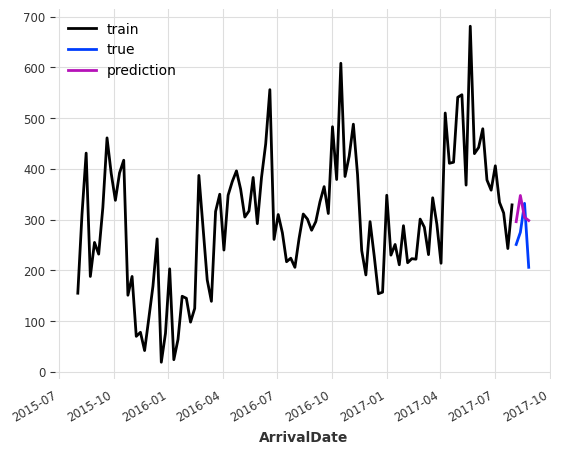

In [77]:
# %%
train.plot(label="train")
test.plot(label="true")
forecast.plot(label="prediction")

In [78]:

# %%
# Search for the best theta parameter, by trying 50 different values
thetas = 2- np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0




for theta in thetas:

    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(test))
    res = mape(test, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta


In [79]:
best_theta

0.16326530612244916

In [80]:

# %%
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(test))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(test, pred_best_theta), best_theta
    )
)


The MAPE is: 17.34, with theta = 0.16326530612244916.


<Axes: xlabel='ArrivalDate'>

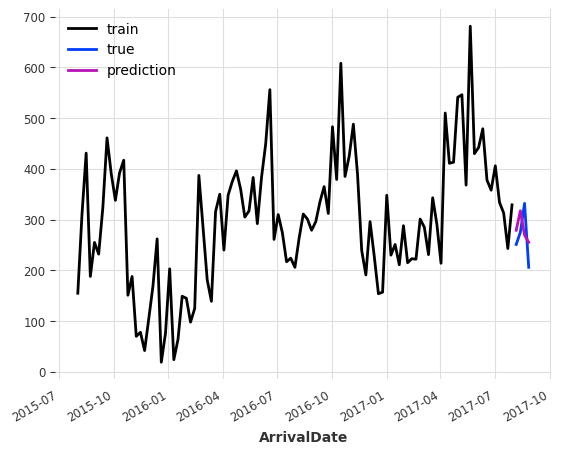

In [81]:
# %%
train.plot(label="train")
test.plot(label="true")
pred_best_theta.plot(label="prediction")

In [82]:
best_theta_mape_c = mape(test, pred_best_theta)
best_theta_mape_c

17.341179577222217

------

# 4Theta

In [83]:
model_4theta =FourTheta(seasonality_period=52)
model_4theta.fit(train)
matlab_4theta_pred = model_4theta.predict(len(test))
print("model {} obtains MAPE: {:.2f}%".format(model_4theta, mape(test, matlab_4theta_pred)))

model FourTheta(seasonality_period=52) obtains MAPE: 85.33%


Text(0.5, 1.0, 'model 4Theta')

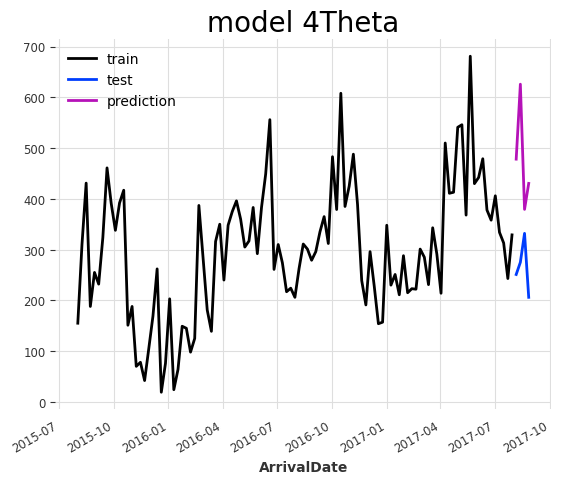

In [84]:
train.plot(label="train")
test.plot(label="test")
matlab_4theta_pred.plot(label="prediction")

plt.title(label="model 4Theta",
          fontsize=20,
          color="black")

In [85]:
fourtheta_grid = {
    'theta':[-4,-3,-2,-1,1,2,3,4],
    'model_mode': [ModelMode.ADDITIVE,ModelMode.MULTIPLICATIVE],
    'season_mode': [SeasonalityMode.MULTIPLICATIVE,SeasonalityMode.ADDITIVE],
    'trend_mode': [TrendMode.EXPONENTIAL,TrendMode.LINEAR]
}

best_grid_model=FourTheta.gridsearch(parameters=fourtheta_grid,
                                series=train,
                                forecast_horizon=4, # 12
                                start=0.85,
                                last_points_only=False,
                                metric=mape,
                                reduction=np.mean,
                                verbose=False,
                                n_jobs=-1)

best_grid_model

/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/codespace/.python/current/lib/pyth

(FourTheta(theta=-2, seasonality_period=None, season_mode=SeasonalityMode.ADDITIVE, model_mode=ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL, normalization=True),
 {'theta': -2,
  'model_mode': <ModelMode.MULTIPLICATIVE: 'multiplicative'>,
  'season_mode': <SeasonalityMode.ADDITIVE: 'additive'>,
  'trend_mode': <TrendMode.EXPONENTIAL: 'exponential'>},
 23.545129674364855)

Text(0.5, 1.0, 'Best 4Theta model')

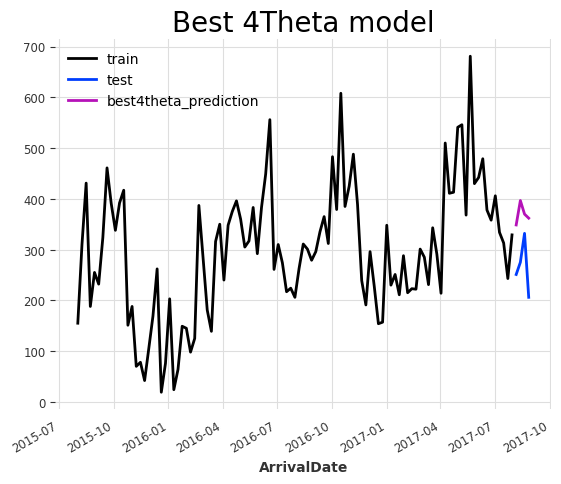

In [86]:
best4Theta_model=FourTheta(theta=best_grid_model[1]['theta'],
                 model_mode=ModelMode.MULTIPLICATIVE,
                 season_mode=SeasonalityMode.ADDITIVE,
                 trend_mode=TrendMode.EXPONENTIAL
                 )
best4Theta_model.fit(train)
best4Theta_model_prediction = best4Theta_model.predict(len(test))

train.plot(label="train")
test.plot(label="test")
best4Theta_model_prediction.plot(label="best4theta_prediction")

plt.title(label="Best 4Theta model",
          fontsize=20,
          color="black")

In [87]:
best4theta_mape_c = mape(test, best4Theta_model_prediction)
best4theta_mape_c

42.56762984078841

-------

# TBATS

In [88]:
from darts.models import TBATS

In [90]:
model_tbats =TBATS(
use_box_cox=None,
box_cox_bounds=(0, 1),
use_trend=None,
use_damped_trend=None,
seasonal_periods="freq",
use_arma_errors=True,
show_warnings=False,
multiprocessing_start_method='spawn',
random_state=0)
model_tbats.fit(train)
prediction_tbats = model_tbats.predict(len(test))

<Axes: xlabel='ArrivalDate'>

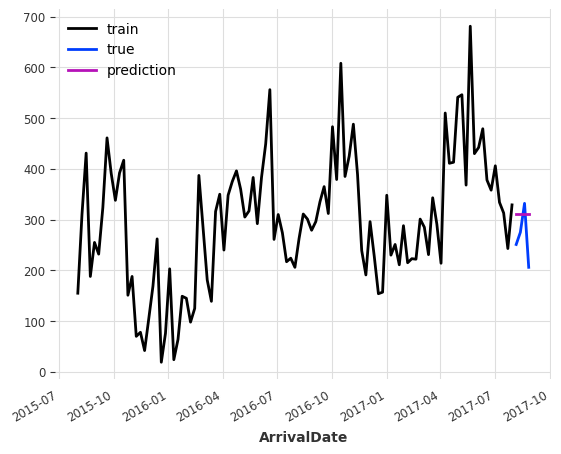

In [91]:
train.plot(label="train")
test.plot(label="true")
prediction_tbats.plot(label="prediction")

In [92]:
tbats_mape_c = mape(test, prediction_tbats)
tbats_mape_c

23.425133572221128

In [93]:
best_theta_mape_r = best_theta_mape_r / 100

In [94]:
best4theta_mape_r = best4theta_mape_r /100

In [95]:
tbats_mape_r = tbats_mape_r /100

In [96]:
best_theta_mape_c = best_theta_mape_c / 100

In [97]:
best4theta_mape_c = best4theta_mape_c /100

In [98]:
tbats_mape_c = tbats_mape_c /100

------

# Tabla MAPE's de los modelos

In [99]:
mape_reservas = pd.read_csv('mape_reservas.csv')
mape_reservas = mape_reservas.drop(columns='Unnamed: 0')
nuevo_registro = pd.DataFrame({'Modelo_Reservas': ['Best_THETA'], 'MAPE': [best_theta_mape_r]})
nuevo_registro2 =  pd.DataFrame({'Modelo_Reservas': ['Best_4THETA'], 'MAPE': [best4theta_mape_r]})
nuevo_registro3 =  pd.DataFrame({'Modelo_Reservas': ['TBATS'], 'MAPE': [tbats_mape_r]})
mape_reservas = pd.concat([mape_reservas, nuevo_registro, nuevo_registro2, nuevo_registro3], ignore_index=True)
mape_reservas = mape_reservas.sort_values('MAPE')
mape_reservas

,Modelo_Reservas,MAPE
2,Best_THETA,0.028940
4,TBATS,0.043893
3,Best_4THETA,0.062771
0,ARIMA,0.086322
1,ETS,0.158757


In [100]:
mape_cancelaciones = pd.read_csv('mape_cancelaciones.csv')
mape_cancelaciones = mape_cancelaciones.drop(columns='Unnamed: 0')
nuevo_registro = pd.DataFrame({'Modelo_Cancelaciones': ['Best_THETA'], 'MAPE': [best_theta_mape_c]})
nuevo_registro2 =  pd.DataFrame({'Modelo_Cancelaciones': ['Best_4THETA'], 'MAPE': [best4theta_mape_c]})
nuevo_registro3 =  pd.DataFrame({'Modelo_Cancelaciones': ['TBATS'], 'MAPE': [tbats_mape_c]})
mape_cancelaciones = pd.concat([mape_cancelaciones, nuevo_registro, nuevo_registro2, nuevo_registro3], ignore_index=True)
mape_cancelaciones = mape_cancelaciones.sort_values('MAPE')
mape_cancelaciones

,Modelo_Cancelaciones,MAPE
2,Best_THETA,0.173412
4,TBATS,0.234251
0,ARIMA,0.251014
3,Best_4THETA,0.425676
1,ETS,0.573190


In [101]:
mape_reservas.to_csv('mape_reservas.csv')

In [102]:
mape_cancelaciones.to_csv('mape_cancelaciones.csv')